## Train the Model

In [44]:
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

img_width, img_height = 224, 224
batch_size = 32
epochs = 10
num_classes = 5

def prepare_data():
    dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

    train_dataset = dataset['train'].shuffle(1000).take(3000)
    validation_dataset = dataset['train'].skip(3000).take(500)

    base_dir = 'flower_dataset'
    os.makedirs(base_dir, exist_ok=True)

    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    for class_name in info.features['label'].names:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

    def save_images(dataset, directory):
        for img, label in dataset:
            class_name = info.features['label'].names[label]
            img = tf.image.resize(img, (img_width, img_height))
            img = tf.cast(img, tf.uint8)
            tf.keras.preprocessing.image.save_img(
                os.path.join(directory, class_name, f'{tf.strings.as_string(label)}_{tf.strings.as_string(tf.timestamp())}.jpg'),
                img
            )

    save_images(train_dataset, train_dir)
    save_images(validation_dataset, validation_dir)

    return train_dir, validation_dir

train_data_dir, validation_data_dir = prepare_data()

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

model.save('flower_classification_model.h5')

evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Found 3000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Epoch 1/10
93/93 [==============================] - 51s 517ms/step - loss: 0.9710 - accuracy: 0.6877 - val_loss: 0.5953 - val_accuracy: 0.7937
Epoch 2/10
93/93 [==============================] - 47s 508ms/step - loss: 0.4684 - accuracy: 0.8322 - val_loss: 0.4714 - val_accuracy: 0.8375
Epoch 3/10
93/93 [==============================] - 44s 468ms/step - loss: 0.3764 - accuracy: 0.8578 - val_loss: 0.3990 - val_accuracy: 0.8708
Epoch 4/10
93/93 [==============================] - 46s 496ms/step - loss: 0.3061 - accuracy: 0.8881 - val_loss: 0.3450 - val_accuracy: 0.8896
Epoch 5/10
93/93 [==============================] - 45s 480ms/step - loss: 0.2547 - accuracy: 0.9046 - val_loss: 0.3237 - val_accuracy: 0.8979
Epoch 6/10
93/93 [==============================] - 45s 482ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 8s 499ms/step - loss: 0.2598 - accuracy: 0.9220
Validation Loss: 0.2598245441913605
Validation Accuracy: 0.921999990940094


## Run the saved MODEL

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

model = load_model('flower_classification_model.h5')



In [2]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
from tensorflow.keras.preprocessing import image 

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    return img, predicted_class, confidence

In [3]:
import matplotlib.pyplot as plt
import os


def show_predictions(image_dir):
    plt.figure(figsize=(15, 15))
    
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Directory not found: {class_dir}")
            continue
        
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"No images found in {class_dir}")
            continue
        
        image_path = os.path.join(class_dir, image_files[0])  # Get the first image
        img, predicted_class, confidence = predict_image(image_path)
        
        plt.subplot(3, 2, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_name}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}")
        plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


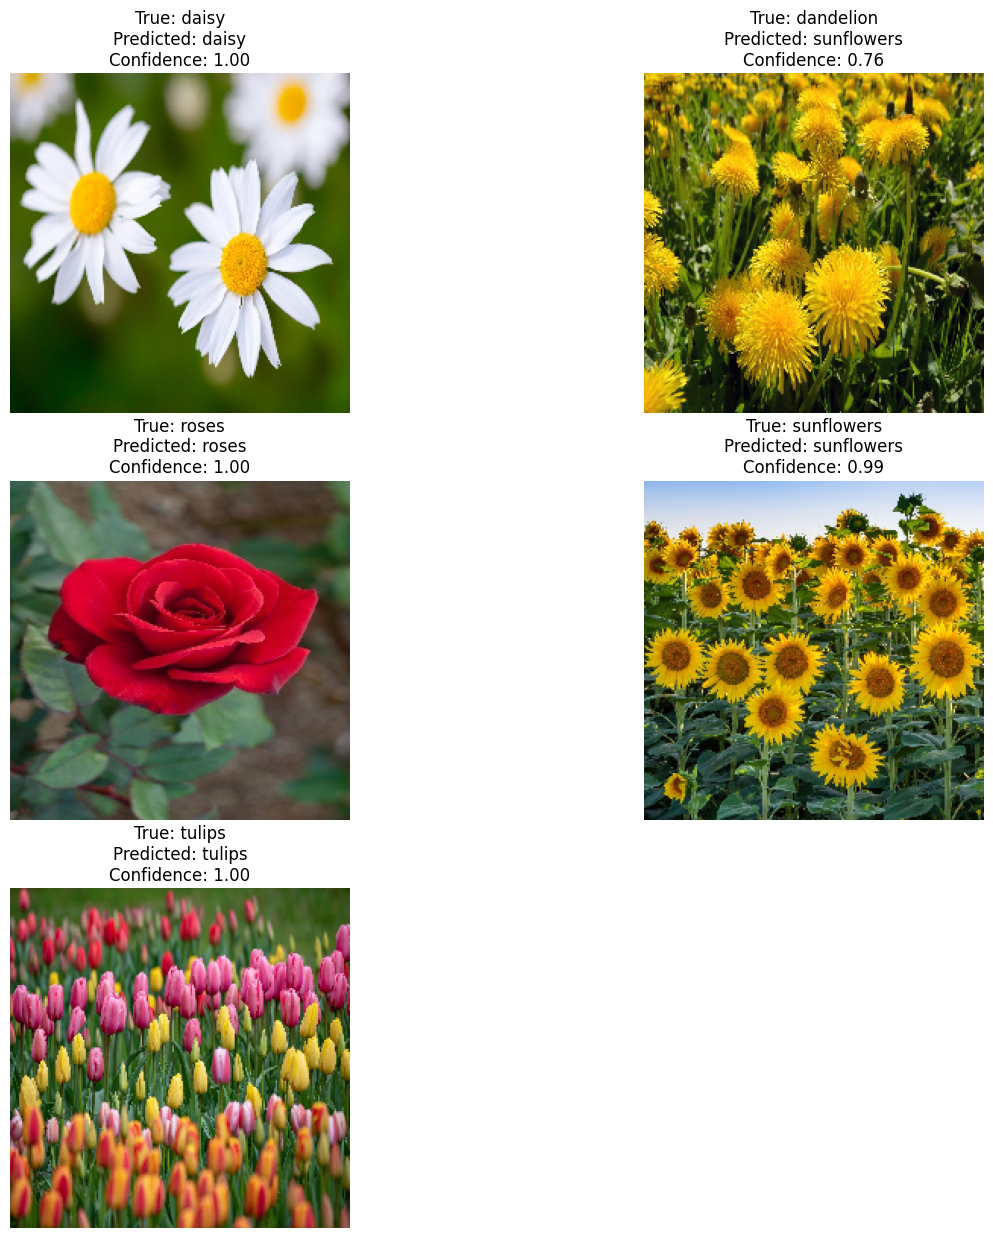

In [4]:
image_dir = 'Images'

show_predictions(image_dir)